In [1]:
using Distributions, CairoMakie, Base.Threads, ColorSchemes

# Psychometric functions
In psychophysics we tend to try and find the boundary between two barely distinguishable events. That might be the absence vs presence of a stimulus or the exact change in stimulus parameter required to observe a difference. 

Signal detection theory treats all events as distributions from which the intensity can be sampled at a given point in time. The practical consequence of this is that when the stimulus is delivered on two (or N) separate occasions two (or N) different events will be perceived - depending on the sample from the distribution. To contextualize this in standard psychophysical tasks, in discrimination there is the standard stimulus with a given distribution. We then adjust a parameter in an attempt to shift the distribution of the comparison stimulus such that it no longer intersects with the distribution of the standard stimulus. Detection tasks are variants of this where the standard stimulus is no stimulus. When conceptualizing these distributions it is common to use an established uniform distribution (usually a normal/gaussian) and assume that all stimulus events represents samples from these distributions.

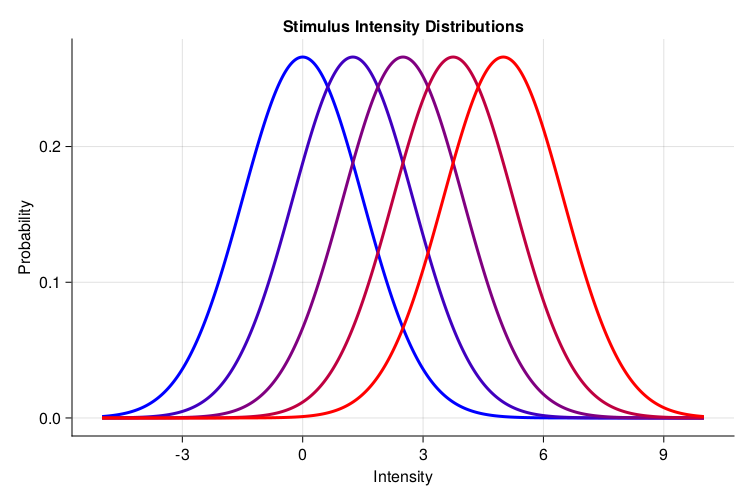

In [2]:
Fig = Figure(resolution = (750, 500))
Ax = Axis(Fig[1,1], title = "Stimulus Intensity Distributions", xlabel = "Intensity", ylabel = "Probability",
  topspinevisible = false, rightspinevisible = false)

sigma = 1.5 # This value can be changed to control the noise term
x = LinRange(-5, 10, Int(1e4))
means = LinRange(0, 5, 5)
cs = cgrad([:blue, :red], length(means)) # Color scheme from blue to red
for (m, c) in zip(means, cs)
    d = Normal(m, sigma)
    lines!(Ax, x ,d, color = c, linewidth = 3)
    # text!(Ax, m, 0.3, text = "$m", align = (:center, :baseline))
end
display(Fig);

The variance in the intensity is thought to originate from a common noise source. Consequently, the standard deviation of each stimulus levels perceptual intensity is constant and changing the stimulus intensity merely 'pushes' the distribution rightward. For each stimulus level, the proportion of times the comparison stimulus is discriminated or the stimulus is detected represents the proportion of the distribution above outside the standard distribution or above the detection threshold. The most common metric for discriminability is called _d'_ (d-prime).

The _d'_ can be computed as the difference in means between the two distributions divided by the standard deviation:
$ d' = \frac{\Delta\mu}{\sigma}$

OR as the Z-score transform of the hit rate minus the Z-score transform of the false alarm rate, where we consider the classic quadrant response type:
| | Signal Present | Signal Absent |
|---|---|---|
| **Detected** | Hit | False Alarm |
| **Not Detected** | Miss | Correct Reject |

Thus: $ d' = Z(hit) - Z(fa)$

Similarly, we can directly compute the probability of selecting the comparison stimulus which represents the _hit_ rate in the above table. However, it is worth noting that this can be misleading if the _false alarm_ rate is not taken into consideration.

Below we can see the _d'_ computed either way from the above distributions as well as the detection rate.

In [3]:
for m in means
  # Compute optimal criterion half way between the two means
  crit = (m - means[1]) / 2
  # Compute false alarm and hit rates for each distribution
  fa = 1 - cdf(Normal(means[1], sigma), crit)
  hit = 1 - cdf(Normal(m, sigma), crit)
  # Compute dprime_z
  dpz = quantile(Normal(), hit) - quantile(Normal(), fa) # Use the standard Normal distribution function
  # Simpler delta mu method
  dpm = (m - means[1]) / sigma
  println("μ = $m:\td'(Z) = $(round(dpz, digits = 2)), \td'(μ) = $(round(dpm, digits = 2)),\tprob = $(round(hit, digits = 2))")
end

μ = 0.0:	d'(Z) = 0.0, 	d'(μ) = 0.0,	prob = 0.5
μ = 1.25:	d'(Z) = 0.83, 	d'(μ) = 0.83,	prob = 0.66
μ = 2.5:	d'(Z) = 1.67, 	d'(μ) = 1.67,	prob = 0.8
μ = 3.75:	d'(Z) = 2.5, 	d'(μ) = 2.5,	prob = 0.89
μ = 5.0:	d'(Z) = 3.33, 	d'(μ) = 3.33,	prob = 0.95


We can then plot the probability at each intensity value and produce an ogival curve that resembles a cumulative normal distribution - the psychometric function. Note, however, that the exact formulation differs for detection and discrimination as in the case of detection the probability only increases when the intensity is above some unknown criterion (the detection threshold) versus the optimal criterion half way between the two distributions. Note that in the below code only the hit rate is used and the false alarm rate is ignored. This is acceptable for perfect (simulated) subjects but is not adequate in real world testing.

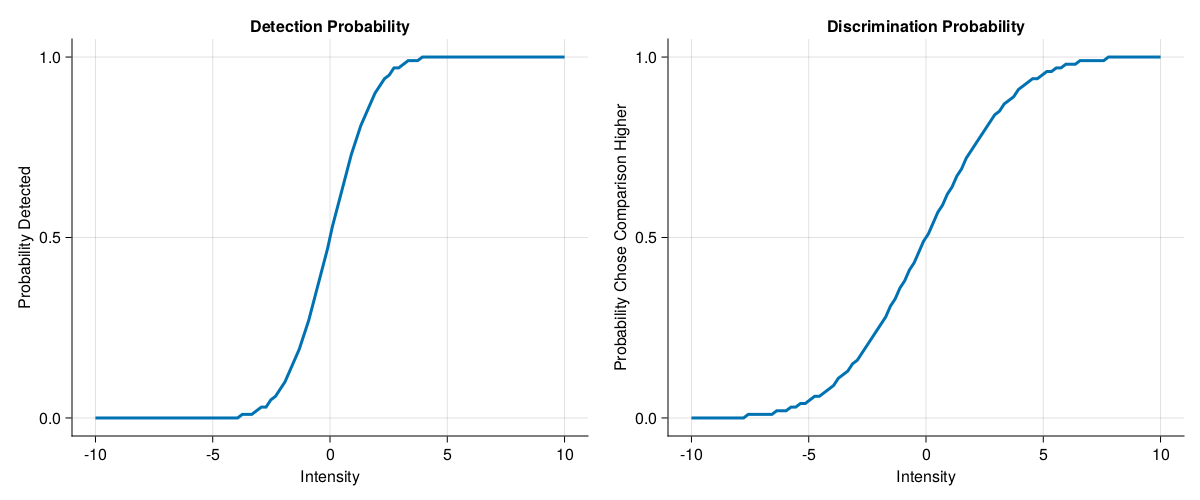

In [4]:
p_discrim = fill(0.0, 100)
p_detect = fill(0.0, 100)
x = LinRange(-10, 10, 100)
for (i, m) = enumerate(x)
    # Discrimination
    crit = m / 2 # Midpoint of the two means
    hit = 1 - cdf(Normal(m, sigma), crit)
    p_discrim[i] = round(hit, digits = 2)

    # detection
    hit = 1 - cdf(Normal(m, sigma), 0) # Criterion is always 0
    p_detect[i] = round(hit, digits = 2) # Only need the hit rate
end

Fig = Figure(resolution = (1200, 500))
Ax1 = Axis(Fig[1,1], title = "Detection Probability", xlabel = "Intensity", ylabel = "Probability Detected",
  topspinevisible = false, rightspinevisible = false)
lines!(Ax1, x, p_detect, linewidth = 3)

Ax2 = Axis(Fig[1,2], title = "Discrimination Probability", xlabel = "Intensity", ylabel = "Probability Chose Comparison Higher",
  topspinevisible = false, rightspinevisible = false)
lines!(Ax2, x, p_discrim, linewidth = 3)
display(Fig);

Participants rarely know their criterion and sensitivity, however, and so we must experimentally probe and estimate the underlying distribution that explains their behavior. The following notebooks will examine different methods for estimating these psychometric functions.